In [1]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.base_models.source_kinet import kiunet, reskiunet, densekiunet, kiunet3d
from trustworthai.models.base_models.torchUNet import UNet, UNet3D
from trustworthai.models.base_models.deepmedic import DeepMedic

# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.tversky_loss import TverskyLoss
from trustworthai.utils.losses_and_metrics.misc_metrics import IOU
from trustworthai.utils.losses_and_metrics.dice import dice, DiceMetric
from trustworthai.utils.losses_and_metrics.dice_losses import DiceLoss
from trustworthai.utils.losses_and_metrics.power_jaccard_loss import PowerJaccardLoss
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper, get_trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

In [2]:
print("sdf")

sdf


### Set the seed

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
### Set the GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2" # blocks gpu 0
# torch.cuda.device_count()

### define datasets and dataloaders

In [5]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [6]:
domains = [
            wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ] + [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [7]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        # RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
    ]
    if not is_3D:
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        return PairedCompose(transforms)

In [8]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [9]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
# datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=None) for domain in domains]
datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(219, 61, 30)

In [11]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

### setup model

In [12]:
# from trustworthai.models.base_models.source_kinet import kiunet, reskiunet, densekiunet, kiunet3d
# from trustworthai.models.base_models.torchUNet import UNet, UNet3D
# from trustworthai.models.base_models.deepmedic import DeepMedic

in_channels = 3
out_channels = 1

# fpr 2D models
# select a 2D dataloader
# for standard UNet
#model = UNet(in_channels, out_channels, init_features=32, dropout_p=0.)

# model = kiunet(in_channels, out_channels)
# model = densekiunet(in_channels, out_channels)
# model = reskiunet(in_channels, out_channels)

# deepmedic
# SCALE_FACTORS = ((3, 3, 3), (1, 1, 1))
# FEATURE_MAPS = (30, 30, 40, 40, 40, 40, 50, 50)
# FULLY_CONNECTED = (250, 250)
# DROPOUT = (.0, .5, .5)
# model = DeepMedic(in_channels,
#                  out_channels,
#                  scale_factors=SCALE_FACTORS,
#                  feature_maps=FEATURE_MAPS,
#                  fully_connected=FULLY_CONNECTED,
#                  dropout=DROPOUT)

# # for 3D models
# # select a 3D dataloader (note you will have a very few validation/test samples when using just the WMH dataset)
# # as there are only 60 scans across the entire dataset.

# # for 3D Unet:
model = UNet3D(in_channels=3, out_channels=1, init_features=32, dropout_p=0.)
#model = UNet_3D(in_channels=3, out_channels=1, init_features=32, dropout_p=0.)
# # for kinet
# model = kiunet3d(c=in_channels, num_classes=out_channels)


# SCALE_FACTORS = ((1,5,5), (1, 3, 3), (1, 1, 1))
# FEATURE_MAPS = (30, 30, 40, 40, 40, 40, 50, 50)
# FULLY_CONNECTED = (250, 250)
# DROPOUT = (.0, .5, .5)
# model = DeepMedic(in_channels,
#                  out_channels,
#                  scale_factors=SCALE_FACTORS,
#                  feature_maps=FEATURE_MAPS,
#                  fully_connected=FULLY_CONNECTED,
#                  dropout=DROPOUT)

#loss = DiceLoss()
#loss = TverskyLoss()
# loss = PowerJaccardLoss()
loss = BCELoss()

In [13]:
from torch import nn
class testUNet3D(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=16, dropout_p=0.1, softmax=True):
        super().__init__()

        features = init_features
        self.encoder1 = UNet3D._block(in_channels, features, name="enc1", dropout_p=dropout_p)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder2 = UNet3D._block(features, features * 2, name="enc2", dropout_p=dropout_p)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder3 = UNet3D._block(features * 2, features * 4, name="enc3", dropout_p=dropout_p)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder4 = UNet3D._block(features * 4, features * 8, name="enc4", dropout_p=dropout_p)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.bottleneck = UNet3D._block(features * 8, features * 16, name="bottleneck", dropout_p=dropout_p)

        self.upconv4 = nn.ConvTranspose3d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet3D._block((features * 8) * 2, features * 8, name="dec4", dropout_p=dropout_p)
        self.upconv3 = nn.ConvTranspose3d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet3D._block((features * 4) * 2, features * 4, name="dec3", dropout_p=dropout_p)
        self.upconv2 = nn.ConvTranspose3d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet3D._block((features * 2) * 2, features * 2, name="dec2", dropout_p=dropout_p)
        self.upconv1 = nn.ConvTranspose3d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet3D._block(features * 2, features, name="dec1", dropout_p=dropout_p)

        self.conv = nn.Conv3d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        self.do_softmax = softmax

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        out = self.conv(dec1)
        if self.do_softmax:
            return torch.nn.functional.softmax(out)
        else:
            return out

    @staticmethod
    def _block(in_channels, features, name, dropout_p):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv3d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm3d(num_features=features)),
                    #(name + "dropout1", nn.Dropout3d(dropout_p)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv3",
                        nn.Conv3d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm3d(num_features=features)),
                    #(name + "dropout2", nn.Dropout3d(dropout_p)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [14]:
def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)

class _AbstractDiceLoss(nn.Module):
    """
    Base class for different implementations of Dice loss.
    """

    def __init__(self, weight=None, normalization='sigmoid'):
        super(_AbstractDiceLoss, self).__init__()
        self.register_buffer('weight', weight)
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify `normalization=Softmax`
        assert normalization in ['sigmoid', 'softmax', 'none']
        if normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        elif normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        else:
            self.normalization = lambda x: x

    def dice(self, input, target, weight):
        # actual Dice score computation; to be implemented by the subclass
        raise NotImplementedError

    def forward(self, input, target):
        # get probabilities from logits
        input = self.normalization(input)

        # compute per channel Dice coefficient
        per_channel_dice = self.dice(input, target, weight=self.weight)

        # average Dice score across all channels/classes
        return 1. - torch.mean(per_channel_dice)

class GeneralizedDiceLoss(_AbstractDiceLoss):
    """Computes Generalized Dice Loss (GDL) as described in https://arxiv.org/pdf/1707.03237.pdf.
    """

    def __init__(self, normalization='sigmoid', epsilon=1e-6):
        super().__init__(weight=None, normalization=normalization)
        self.epsilon = epsilon

    def dice(self, input, target, weight):
        assert input.size() == target.size(), "'input' and 'target' must have the same shape"
        
        input = flatten(input)
        target = flatten(target)
        target = target.float()

        if input.size(0) == 1:
            # for GDL to make sense we need at least 2 channels (see https://arxiv.org/pdf/1707.03237.pdf)
            # put foreground and background voxels in separate channels
            input = torch.cat((input, 1 - input), dim=0)
            target = torch.cat((target, 1 - target), dim=0)

        # GDL weighting: the contribution of each label is corrected by the inverse of its volume
        w_l = target.sum(-1)
        w_l = 1 / (w_l * w_l).clamp(min=self.epsilon)
        w_l.requires_grad = False

        intersect = (input * target).sum(-1)
        intersect = intersect * w_l

        denominator = (input + target).sum(-1)
        denominator = (denominator * w_l).clamp(min=self.epsilon)

        return 2 * (intersect.sum() / denominator.sum())

In [23]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

import torch
import torch.nn as nn
import torch.nn.functional as F

class StandardLitModelWrapper2(pl.LightningModule):
    def __init__(self, model, loss=F.cross_entropy, logging_metrics=None):
        super().__init__()
        """
        logging metrics are (name, metric function)
        """
        self.model = model
        self.loss = loss
        self.logging_metrics = nn.ModuleList(logging_metrics)

        
    def forward(self, x, *args, **kwargs):
        return self.model(x, *args, **kwargs)
    
    def configure_optimizers(self):
        # optimizer and schedulers go in the configure optimizers hook
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        """
        lightning automates the training loop, 
        does epoch, back_tracking, optimizers and schedulers,
        and metric reduction.
        we just define how we want to process a single batch. 
        we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
        hook, and I presume we can add our own parameters also to functions?
        """
        X, y = batch
        y_hat = self(X)
        loss = self.loss(y_hat, y)
        
        # metrics 
        if self.logging_metrics != None:
            for i, lm in enumerate(self.logging_metrics):
                value = lm[1](y_hat, y)
                self.log(f"metric: {i+1}", value, prog_bar=True)
        self.log("train_loss", loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        """
        note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
        well yes I want to enable checkpointing but will deal with that later.
        also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
        I will need a custom eval thing to do my dropout estimation but can solve that later too.
        """
        X, y = batch
        y_hat = self(X)
        val_loss = self.loss(y_hat, y)
        
        if self.logging_metrics != None:
            for i, lm in enumerate(self.logging_metrics):
                value = lm[1](y_hat, y)
                self.log(f"metric: {i+1}", value, prog_bar=True)
        self.log("val_loss", val_loss)
        
    def test_step(self, batch, batch_idx):
        """
        we would need to directly call this function using the trainer
        """
        X, y = batch
        y_hat = self(X)
        test_loss = self.loss(y_hat, y)
        self.log("test_loss", test_loss)
        
    def predict_step(self, batch, batch_idx):
        """
        just for making predictions as opposed to collecting metrics etc
        note to use this, we just call .predict(dataloader) and it then automates the look
        these functions are for a single batch. Nice.
        """
        X, y = batch
        pred = self(X)
        return pred

In [32]:
model = testUNet3D(in_channels=3, out_channels=1, init_features=16, dropout_p=0., softmax=False)
#model = ResidualUNet3D(in_channels=3, out_channels=1)
loss = GeneralizedDiceLoss(normalization='sigmoid')
#loss=BCEWithLogitsLoss()

In [33]:
metrics=None#[DiceMetric()]
# note metrics only work properly when not using distributed stategies I think.
# see pytorchlightning guidance on metrics.


#model = StandardLitModelWrapper2(model, train_dataloader, test_dataloader, val_dataloader, None, loss, metrics)
chpt = "/disk/scratch/s2208943/results/epoch=103-step=728.ckpt"
model = StandardLitModelWrapper2.load_from_checkpoint(chpt, model=model, 
                                                      train_dataloader=train_dataloader,
                                                      val_dataloader=val_dataloader,
                                                      test_dataloader=test_dataloader,
                                                      loss=loss)

In [34]:
checkpoint_dir = "/disk/scratch/s2208943/results/"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=2000
precision = 16

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=100, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [36]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.25529372692108154
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.25529372692108154}]

In [35]:
trainer.validate(model, train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.28326401114463806
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.28326401114463806}]

In [37]:
trainer.validate(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.23687617480754852
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.23687617480754852}]

### train

In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

Missing logger folder: /disk/scratch/s2208943/results/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                | Params
--------------------------------------------------------
0 | model           | testUNet3D          | 5.6 M 
1 | loss            | GeneralizedDiceLoss | 0     
2 | logging_metrics | ModuleList          | 0     
--------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
11.294    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.985


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.971


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.962


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f774a4011f0>
Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
      File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f774a4011f0>
Traceback (most recent call last):
  File "/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/torch/utils/data/dataloader.py", l

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.959


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.954


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.943


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.939


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.929


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.924


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.916


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.899


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.892


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.849


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.845


In [165]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.2848452627658844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.2848452627658844}]

In [118]:
x = next(iter(train_dataloader))

In [119]:
x[0].shape

torch.Size([16, 3, 32, 224, 160])

In [38]:
preds = trainer.predict(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [52]:
preds0 = torch.sigmoid(preds[0].type(torch.float32))

In [53]:
preds[0].shape

torch.Size([16, 1, 32, 224, 160])

In [54]:
x = next(iter(val_dataloader))

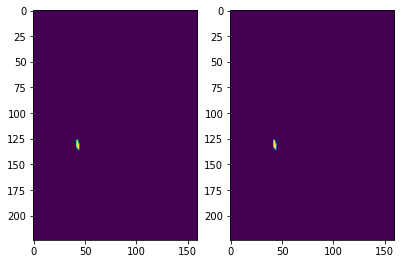

In [55]:
plt.figure(figsize=(10,5))
islice=10
n = 3
plt.subplot(1,3,1)
plt.imshow(preds0[n,0,islice,:,:])
plt.subplot(1,3,2)
plt.imshow(preds0[n,0,islice,:,:]); plt.show()

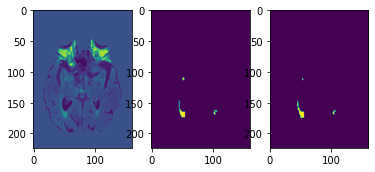

In [61]:
islice=20
n = 4
plt.subplot(1,3,1)
plt.imshow(x[0][n,0,islice,:,:])
plt.subplot(1,3,2)
plt.imshow(x[1][n,0,islice,:,:])
plt.subplot(1,3,3)
plt.imshow(preds0[n,0,islice,:,:])
plt.show()

In [60]:
dice(preds0>0.5, x[1])

tensor(0.7701)

In [65]:
import importlib
import logging
import os
import shutil
import sys

#import h5py
import numpy as np
import torch
from torch import optim


def save_checkpoint(state, is_best, checkpoint_dir):
    """Saves model and training parameters at '{checkpoint_dir}/last_checkpoint.pytorch'.
    If is_best==True saves '{checkpoint_dir}/best_checkpoint.pytorch' as well.
    Args:
        state (dict): contains model's state_dict, optimizer's state_dict, epoch
            and best evaluation metric value so far
        is_best (bool): if True state contains the best model seen so far
        checkpoint_dir (string): directory where the checkpoint are to be saved
    """

    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)

    last_file_path = os.path.join(checkpoint_dir, 'last_checkpoint.pytorch')
    torch.save(state, last_file_path)
    if is_best:
        best_file_path = os.path.join(checkpoint_dir, 'best_checkpoint.pytorch')
        shutil.copyfile(last_file_path, best_file_path)


def load_checkpoint(checkpoint_path, model, optimizer=None,
                    model_key='model_state_dict', optimizer_key='optimizer_state_dict'):
    """Loads model and training parameters from a given checkpoint_path
    If optimizer is provided, loads optimizer's state_dict of as well.
    Args:
        checkpoint_path (string): path to the checkpoint to be loaded
        model (torch.nn.Module): model into which the parameters are to be copied
        optimizer (torch.optim.Optimizer) optional: optimizer instance into
            which the parameters are to be copied
    Returns:
        state
    """
    if not os.path.exists(checkpoint_path):
        raise IOError(f"Checkpoint '{checkpoint_path}' does not exist")

    state = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(state[model_key])

    if optimizer is not None:
        optimizer.load_state_dict(state[optimizer_key])

    return state


def save_network_output(output_path, output, logger=None):
    if logger is not None:
        logger.info(f'Saving network output to: {output_path}...')
    output = output.detach().cpu()[0]
    with h5py.File(output_path, 'w') as f:
        f.create_dataset('predictions', data=output, compression='gzip')


loggers = {}


def get_logger(name, level=logging.INFO):
    global loggers
    if loggers.get(name) is not None:
        return loggers[name]
    else:
        logger = logging.getLogger(name)
        logger.setLevel(level)
        # Logging to console
        stream_handler = logging.StreamHandler(sys.stdout)
        formatter = logging.Formatter(
            '%(asctime)s [%(threadName)s] %(levelname)s %(name)s - %(message)s')
        stream_handler.setFormatter(formatter)
        logger.addHandler(stream_handler)

        loggers[name] = logger

        return logger


def get_number_of_learnable_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])


class RunningAverage:
    """Computes and stores the average
    """

    def __init__(self):
        self.count = 0
        self.sum = 0
        self.avg = 0

    def update(self, value, n=1):
        self.count += n
        self.sum += value * n
        self.avg = self.sum / self.count


def find_maximum_patch_size(model, device):
    """Tries to find the biggest patch size that can be send to GPU for inference
    without throwing CUDA out of memory"""
    logger = get_logger('PatchFinder')
    in_channels = model.in_channels

    patch_shapes = [(64, 128, 128), (96, 128, 128),
                    (64, 160, 160), (96, 160, 160),
                    (64, 192, 192), (96, 192, 192)]

    for shape in patch_shapes:
        # generate random patch of a given size
        patch = np.random.randn(*shape).astype('float32')

        patch = torch \
            .from_numpy(patch) \
            .view((1, in_channels) + patch.shape) \
            .to(device)

        logger.info(f"Current patch size: {shape}")
        model(patch)


def remove_halo(patch, index, shape, patch_halo):
    """
    Remove `pad_width` voxels around the edges of a given patch.
    """
    assert len(patch_halo) == 3

    def _new_slices(slicing, max_size, pad):
        if slicing.start == 0:
            p_start = 0
            i_start = 0
        else:
            p_start = pad
            i_start = slicing.start + pad

        if slicing.stop == max_size:
            p_stop = None
            i_stop = max_size
        else:
            p_stop = -pad if pad != 0 else 1
            i_stop = slicing.stop - pad

        return slice(p_start, p_stop), slice(i_start, i_stop)

    D, H, W = shape

    i_c, i_z, i_y, i_x = index
    p_c = slice(0, patch.shape[0])

    p_z, i_z = _new_slices(i_z, D, patch_halo[0])
    p_y, i_y = _new_slices(i_y, H, patch_halo[1])
    p_x, i_x = _new_slices(i_x, W, patch_halo[2])

    patch_index = (p_c, p_z, p_y, p_x)
    index = (i_c, i_z, i_y, i_x)
    return patch[patch_index], index


def number_of_features_per_level(init_channel_number, num_levels):
    return [init_channel_number * 2 ** k for k in range(num_levels)]


class _TensorboardFormatter:
    """
    Tensorboard formatters converts a given batch of images (be it input/output to the network or the target segmentation
    image) to a series of images that can be displayed in tensorboard. This is the parent class for all tensorboard
    formatters which ensures that returned images are in the 'CHW' format.
    """

    def __init__(self, **kwargs):
        pass

    def __call__(self, name, batch):
        """
        Transform a batch to a series of tuples of the form (tag, img), where `tag` corresponds to the image tag
        and `img` is the image itself.
        Args:
             name (str): one of 'inputs'/'targets'/'predictions'
             batch (torch.tensor): 4D or 5D torch tensor
        """

        def _check_img(tag_img):
            tag, img = tag_img

            assert img.ndim == 2 or img.ndim == 3, 'Only 2D (HW) and 3D (CHW) images are accepted for display'

            if img.ndim == 2:
                img = np.expand_dims(img, axis=0)
            else:
                C = img.shape[0]
                assert C == 1 or C == 3, 'Only (1, H, W) or (3, H, W) images are supported'

            return tag, img

        tagged_images = self.process_batch(name, batch)

        return list(map(_check_img, tagged_images))

    def process_batch(self, name, batch):
        raise NotImplementedError


class DefaultTensorboardFormatter(_TensorboardFormatter):
    def __init__(self, skip_last_target=False, **kwargs):
        super().__init__(**kwargs)
        self.skip_last_target = skip_last_target

    def process_batch(self, name, batch):
        if name == 'targets' and self.skip_last_target:
            batch = batch[:, :-1, ...]

        tag_template = '{}/batch_{}/channel_{}/slice_{}'

        tagged_images = []

        if batch.ndim == 5:
            # NCDHW
            slice_idx = batch.shape[2] // 2  # get the middle slice
            for batch_idx in range(batch.shape[0]):
                for channel_idx in range(batch.shape[1]):
                    tag = tag_template.format(name, batch_idx, channel_idx, slice_idx)
                    img = batch[batch_idx, channel_idx, slice_idx, ...]
                    tagged_images.append((tag, self._normalize_img(img)))
        else:
            # batch has no channel dim: NDHW
            slice_idx = batch.shape[1] // 2  # get the middle slice
            for batch_idx in range(batch.shape[0]):
                tag = tag_template.format(name, batch_idx, 0, slice_idx)
                img = batch[batch_idx, slice_idx, ...]
                tagged_images.append((tag, self._normalize_img(img)))

        return tagged_images

    @staticmethod
    def _normalize_img(img):
        return np.nan_to_num((img - np.min(img)) / np.ptp(img))


def _find_masks(batch, min_size=10):
    """Center the z-slice in the 'middle' of a given instance, given a batch of instances
    Args:
        batch (ndarray): 5d numpy tensor (NCDHW)
    """
    result = []
    for b in batch:
        assert b.shape[0] == 1
        patch = b[0]
        z_sum = patch.sum(axis=(1, 2))
        coords = np.where(z_sum > min_size)[0]
        if len(coords) > 0:
            ind = coords[len(coords) // 2]
            result.append(b[:, ind:ind + 1, ...])
        else:
            ind = b.shape[1] // 2
            result.append(b[:, ind:ind + 1, ...])

    return np.stack(result, axis=0)


def get_tensorboard_formatter(formatter_config):
    if formatter_config is None:
        return DefaultTensorboardFormatter()

    class_name = formatter_config['name']
    m = importlib.import_module('pytorch3dunet.unet3d.utils')
    clazz = getattr(m, class_name)
    return clazz(**formatter_config)


def expand_as_one_hot(input, C, ignore_index=None):
    """
    Converts NxSPATIAL label image to NxCxSPATIAL, where each label gets converted to its corresponding one-hot vector.
    It is assumed that the batch dimension is present.
    Args:
        input (torch.Tensor): 3D/4D input image
        C (int): number of channels/labels
        ignore_index (int): ignore index to be kept during the expansion
    Returns:
        4D/5D output torch.Tensor (NxCxSPATIAL)
    """
    assert input.dim() == 4

    # expand the input tensor to Nx1xSPATIAL before scattering
    input = input.unsqueeze(1)
    # create output tensor shape (NxCxSPATIAL)
    shape = list(input.size())
    shape[1] = C

    if ignore_index is not None:
        # create ignore_index mask for the result
        mask = input.expand(shape) == ignore_index
        # clone the src tensor and zero out ignore_index in the input
        input = input.clone()
        input[input == ignore_index] = 0
        # scatter to get the one-hot tensor
        result = torch.zeros(shape).to(input.device).scatter_(1, input, 1)
        # bring back the ignore_index in the result
        result[mask] = ignore_index
        return result
    else:
        # scatter to get the one-hot tensor
        return torch.zeros(shape).to(input.device).scatter_(1, input, 1)


def convert_to_numpy(*inputs):
    """
    Coverts input tensors to numpy ndarrays
    Args:
        inputs (iteable of torch.Tensor): torch tensor
    Returns:
        tuple of ndarrays
    """

    def _to_numpy(i):
        assert isinstance(i, torch.Tensor), "Expected input to be torch.Tensor"
        return i.detach().cpu().numpy()

    return (_to_numpy(i) for i in inputs)


def create_optimizer(optimizer_config, model):
    learning_rate = optimizer_config['learning_rate']
    weight_decay = optimizer_config.get('weight_decay', 0)
    betas = tuple(optimizer_config.get('betas', (0.9, 0.999)))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)
    return optimizer


def create_lr_scheduler(lr_config, optimizer):
    if lr_config is None:
        return None
    class_name = lr_config.pop('name')
    m = importlib.import_module('torch.optim.lr_scheduler')
    clazz = getattr(m, class_name)
    # add optimizer to the config
    lr_config['optimizer'] = optimizer
    return clazz(**lr_config)


def get_class(class_name, modules):
    for module in modules:
        m = importlib.import_module(module)
        clazz = getattr(m, class_name, None)
        if clazz is not None:
            return clazz
    raise RuntimeError(f'Unsupported dataset class: {class_name}')

In [66]:
from functools import partial

import torch
from torch import nn as nn
from torch.nn import functional as F


def conv3d(in_channels, out_channels, kernel_size, bias, padding):
    return nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding, bias=bias)


def create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding):
    """
    Create a list of modules with together constitute a single conv layer with non-linearity
    and optional batchnorm/groupnorm.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        kernel_size(int or tuple): size of the convolving kernel
        order (string): order of things, e.g.
            'cr' -> conv + ReLU
            'gcr' -> groupnorm + conv + ReLU
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
            'bcr' -> batchnorm + conv + ReLU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    Return:
        list of tuple (name, module)
    """
    assert 'c' in order, "Conv layer MUST be present"
    assert order[0] not in 'rle', 'Non-linearity cannot be the first operation in the layer'

    modules = []
    for i, char in enumerate(order):
        if char == 'r':
            modules.append(('ReLU', nn.ReLU(inplace=True)))
        elif char == 'l':
            modules.append(('LeakyReLU', nn.LeakyReLU(inplace=True)))
        elif char == 'e':
            modules.append(('ELU', nn.ELU(inplace=True)))
        elif char == 'c':
            # add learnable bias only in the absence of batchnorm/groupnorm
            bias = not ('g' in order or 'b' in order)
            modules.append(('conv', conv3d(in_channels, out_channels, kernel_size, bias, padding=padding)))
        elif char == 'g':
            is_before_conv = i < order.index('c')
            if is_before_conv:
                num_channels = in_channels
            else:
                num_channels = out_channels

            # use only one group if the given number of groups is greater than the number of channels
            if num_channels < num_groups:
                num_groups = 1

            assert num_channels % num_groups == 0, f'Expected number of channels in input to be divisible by num_groups. num_channels={num_channels}, num_groups={num_groups}'
            modules.append(('groupnorm', nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)))
        elif char == 'b':
            is_before_conv = i < order.index('c')
            if is_before_conv:
                modules.append(('batchnorm', nn.BatchNorm3d(in_channels)))
            else:
                modules.append(('batchnorm', nn.BatchNorm3d(out_channels)))
        else:
            raise ValueError(f"Unsupported layer type '{char}'. MUST be one of ['b', 'g', 'r', 'l', 'e', 'c']")

    return modules


class SingleConv(nn.Sequential):
    """
    Basic convolutional module consisting of a Conv3d, non-linearity and optional batchnorm/groupnorm. The order
    of operations can be specified via the `order` parameter
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        kernel_size (int or tuple): size of the convolving kernel
        order (string): determines the order of layers, e.g.
            'cr' -> conv + ReLU
            'crg' -> conv + ReLU + groupnorm
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple):
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, order='gcr', num_groups=8, padding=1):
        super(SingleConv, self).__init__()

        for name, module in create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding=padding):
            self.add_module(name, module)


class DoubleConv(nn.Sequential):
    """
    A module consisting of two consecutive convolution layers (e.g. BatchNorm3d+ReLU+Conv3d).
    We use (Conv3d+ReLU+GroupNorm3d) by default.
    This can be changed however by providing the 'order' argument, e.g. in order
    to change to Conv3d+BatchNorm3d+ELU use order='cbe'.
    Use padded convolutions to make sure that the output (H_out, W_out) is the same
    as (H_in, W_in), so that you don't have to crop in the decoder path.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        encoder (bool): if True we're in the encoder path, otherwise we're in the decoder
        kernel_size (int or tuple): size of the convolving kernel
        order (string): determines the order of layers, e.g.
            'cr' -> conv + ReLU
            'crg' -> conv + ReLU + groupnorm
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, encoder, kernel_size=3, order='gcr', num_groups=8, padding=1):
        super(DoubleConv, self).__init__()
        if encoder:
            # we're in the encoder path
            conv1_in_channels = in_channels
            conv1_out_channels = out_channels // 2
            if conv1_out_channels < in_channels:
                conv1_out_channels = in_channels
            conv2_in_channels, conv2_out_channels = conv1_out_channels, out_channels
        else:
            # we're in the decoder path, decrease the number of channels in the 1st convolution
            conv1_in_channels, conv1_out_channels = in_channels, out_channels
            conv2_in_channels, conv2_out_channels = out_channels, out_channels

        # conv1
        self.add_module('SingleConv1',
                        SingleConv(conv1_in_channels, conv1_out_channels, kernel_size, order, num_groups,
                                   padding=padding))
        # conv2
        self.add_module('SingleConv2',
                        SingleConv(conv2_in_channels, conv2_out_channels, kernel_size, order, num_groups,
                                   padding=padding))


class ExtResNetBlock(nn.Module):
    """
    Basic UNet block consisting of a SingleConv followed by the residual block.
    The SingleConv takes care of increasing/decreasing the number of channels and also ensures that the number
    of output channels is compatible with the residual block that follows.
    This block can be used instead of standard DoubleConv in the Encoder module.
    Motivated by: https://arxiv.org/pdf/1706.00120.pdf
    Notice we use ELU instead of ReLU (order='cge') and put non-linearity after the groupnorm.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, order='cge', num_groups=8, **kwargs):
        super(ExtResNetBlock, self).__init__()

        # first convolution
        self.conv1 = SingleConv(in_channels, out_channels, kernel_size=kernel_size, order=order, num_groups=num_groups)
        # residual block
        self.conv2 = SingleConv(out_channels, out_channels, kernel_size=kernel_size, order=order, num_groups=num_groups)
        # remove non-linearity from the 3rd convolution since it's going to be applied after adding the residual
        n_order = order
        for c in 'rel':
            n_order = n_order.replace(c, '')
        self.conv3 = SingleConv(out_channels, out_channels, kernel_size=kernel_size, order=n_order,
                                num_groups=num_groups)

        # create non-linearity separately
        if 'l' in order:
            self.non_linearity = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        elif 'e' in order:
            self.non_linearity = nn.ELU(inplace=True)
        else:
            self.non_linearity = nn.ReLU(inplace=True)

    def forward(self, x):
        # apply first convolution and save the output as a residual
        out = self.conv1(x)
        residual = out

        # residual block
        out = self.conv2(out)
        out = self.conv3(out)

        out += residual
        out = self.non_linearity(out)

        return out


class Encoder(nn.Module):
    """
    A single module from the encoder path consisting of the optional max
    pooling layer (one may specify the MaxPool kernel_size to be different
    than the standard (2,2,2), e.g. if the volumetric data is anisotropic
    (make sure to use complementary scale_factor in the decoder path) followed by
    a DoubleConv module.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        conv_kernel_size (int or tuple): size of the convolving kernel
        apply_pooling (bool): if True use MaxPool3d before DoubleConv
        pool_kernel_size (int or tuple): the size of the window
        pool_type (str): pooling layer: 'max' or 'avg'
        basic_module(nn.Module): either ResNetBlock or DoubleConv
        conv_layer_order (string): determines the order of layers
            in `DoubleConv` module. See `DoubleConv` for more info.
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, conv_kernel_size=3, apply_pooling=True,
                 pool_kernel_size=2, pool_type='max', basic_module=DoubleConv, conv_layer_order='gcr',
                 num_groups=8, padding=1):
        super(Encoder, self).__init__()
        assert pool_type in ['max', 'avg']
        if apply_pooling:
            if pool_type == 'max':
                self.pooling = nn.MaxPool3d(kernel_size=pool_kernel_size)
            else:
                self.pooling = nn.AvgPool3d(kernel_size=pool_kernel_size)
        else:
            self.pooling = None

        self.basic_module = basic_module(in_channels, out_channels,
                                         encoder=True,
                                         kernel_size=conv_kernel_size,
                                         order=conv_layer_order,
                                         num_groups=num_groups,
                                         padding=padding)

    def forward(self, x):
        if self.pooling is not None:
            x = self.pooling(x)
        x = self.basic_module(x)
        return x


class Decoder(nn.Module):
    """
    A single module for decoder path consisting of the upsampling layer
    (either learned ConvTranspose3d or nearest neighbor interpolation) followed by a basic module (DoubleConv or ExtResNetBlock).
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        conv_kernel_size (int or tuple): size of the convolving kernel
        scale_factor (tuple): used as the multiplier for the image H/W/D in
            case of nn.Upsample or as stride in case of ConvTranspose3d, must reverse the MaxPool3d operation
            from the corresponding encoder
        basic_module(nn.Module): either ResNetBlock or DoubleConv
        conv_layer_order (string): determines the order of layers
            in `DoubleConv` module. See `DoubleConv` for more info.
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
        upsample (boole): should the input be upsampled
    """

    def __init__(self, in_channels, out_channels, conv_kernel_size=3, scale_factor=(2, 2, 2), basic_module=DoubleConv,
                 conv_layer_order='gcr', num_groups=8, mode='nearest', padding=1, upsample=True):
        super(Decoder, self).__init__()

        if upsample:
            if basic_module == DoubleConv:
                # if DoubleConv is the basic_module use interpolation for upsampling and concatenation joining
                self.upsampling = InterpolateUpsampling(mode=mode)
                # concat joining
                self.joining = partial(self._joining, concat=True)
            else:
                # if basic_module=ExtResNetBlock use transposed convolution upsampling and summation joining
                self.upsampling = TransposeConvUpsampling(in_channels=in_channels, out_channels=out_channels,
                                                          kernel_size=conv_kernel_size, scale_factor=scale_factor)
                # sum joining
                self.joining = partial(self._joining, concat=False)
                # adapt the number of in_channels for the ExtResNetBlock
                in_channels = out_channels
        else:
            # no upsampling
            self.upsampling = NoUpsampling()
            # concat joining
            self.joining = partial(self._joining, concat=True)

        self.basic_module = basic_module(in_channels, out_channels,
                                         encoder=False,
                                         kernel_size=conv_kernel_size,
                                         order=conv_layer_order,
                                         num_groups=num_groups,
                                         padding=padding)

    def forward(self, encoder_features, x):
        x = self.upsampling(encoder_features=encoder_features, x=x)
        x = self.joining(encoder_features, x)
        x = self.basic_module(x)
        return x

    @staticmethod
    def _joining(encoder_features, x, concat):
        if concat:
            return torch.cat((encoder_features, x), dim=1)
        else:
            return encoder_features + x


def create_encoders(in_channels, f_maps, basic_module, conv_kernel_size, conv_padding, layer_order, num_groups,
                    pool_kernel_size):
    # create encoder path consisting of Encoder modules. Depth of the encoder is equal to `len(f_maps)`
    encoders = []
    for i, out_feature_num in enumerate(f_maps):
        if i == 0:
            encoder = Encoder(in_channels, out_feature_num,
                              apply_pooling=False,  # skip pooling in the firs encoder
                              basic_module=basic_module,
                              conv_layer_order=layer_order,
                              conv_kernel_size=conv_kernel_size,
                              num_groups=num_groups,
                              padding=conv_padding)
        else:
            # TODO: adapt for anisotropy in the data, i.e. use proper pooling kernel to make the data isotropic after 1-2 pooling operations
            encoder = Encoder(f_maps[i - 1], out_feature_num,
                              basic_module=basic_module,
                              conv_layer_order=layer_order,
                              conv_kernel_size=conv_kernel_size,
                              num_groups=num_groups,
                              pool_kernel_size=pool_kernel_size,
                              padding=conv_padding)

        encoders.append(encoder)

    return nn.ModuleList(encoders)


def create_decoders(f_maps, basic_module, conv_kernel_size, conv_padding, layer_order, num_groups, upsample):
    # create decoder path consisting of the Decoder modules. The length of the decoder list is equal to `len(f_maps) - 1`
    decoders = []
    reversed_f_maps = list(reversed(f_maps))
    for i in range(len(reversed_f_maps) - 1):
        if basic_module == DoubleConv:
            in_feature_num = reversed_f_maps[i] + reversed_f_maps[i + 1]
        else:
            in_feature_num = reversed_f_maps[i]

        out_feature_num = reversed_f_maps[i + 1]

        # TODO: if non-standard pooling was used, make sure to use correct striding for transpose conv
        # currently strides with a constant stride: (2, 2, 2)

        _upsample = True
        if i == 0:
            # upsampling can be skipped only for the 1st decoder, afterwards it should always be present
            _upsample = upsample

        decoder = Decoder(in_feature_num, out_feature_num,
                          basic_module=basic_module,
                          conv_layer_order=layer_order,
                          conv_kernel_size=conv_kernel_size,
                          num_groups=num_groups,
                          padding=conv_padding,
                          upsample=_upsample)
        decoders.append(decoder)
    return nn.ModuleList(decoders)


class AbstractUpsampling(nn.Module):
    """
    Abstract class for upsampling. A given implementation should upsample a given 5D input tensor using either
    interpolation or learned transposed convolution.
    """

    def __init__(self, upsample):
        super(AbstractUpsampling, self).__init__()
        self.upsample = upsample

    def forward(self, encoder_features, x):
        # get the spatial dimensions of the output given the encoder_features
        output_size = encoder_features.size()[2:]
        # upsample the input and return
        return self.upsample(x, output_size)


class InterpolateUpsampling(AbstractUpsampling):
    """
    Args:
        mode (str): algorithm used for upsampling:
            'nearest' | 'linear' | 'bilinear' | 'trilinear' | 'area'. Default: 'nearest'
            used only if transposed_conv is False
    """

    def __init__(self, mode='nearest'):
        upsample = partial(self._interpolate, mode=mode)
        super().__init__(upsample)

    @staticmethod
    def _interpolate(x, size, mode):
        return F.interpolate(x, size=size, mode=mode)


class TransposeConvUpsampling(AbstractUpsampling):
    """
    Args:
        in_channels (int): number of input channels for transposed conv
            used only if transposed_conv is True
        out_channels (int): number of output channels for transpose conv
            used only if transposed_conv is True
        kernel_size (int or tuple): size of the convolving kernel
            used only if transposed_conv is True
        scale_factor (int or tuple): stride of the convolution
            used only if transposed_conv is True
    """

    def __init__(self, in_channels=None, out_channels=None, kernel_size=3, scale_factor=(2, 2, 2)):
        # make sure that the output size reverses the MaxPool3d from the corresponding encoder
        upsample = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=kernel_size, stride=scale_factor,
                                      padding=1)
        super().__init__(upsample)


class NoUpsampling(AbstractUpsampling):
    def __init__(self):
        super().__init__(self._no_upsampling)

    @staticmethod
    def _no_upsampling(x, size):
        return x

In [67]:
class Abstract3DUNet(nn.Module):
    """
    Base class for standard and residual UNet.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output segmentation masks;
            Note that that the of out_channels might correspond to either
            different semantic classes or to different binary segmentation mask.
            It's up to the user of the class to interpret the out_channels and
            use the proper loss criterion during training (i.e. CrossEntropyLoss (multi-class)
            or BCEWithLogitsLoss (two-class) respectively)
        f_maps (int, tuple): number of feature maps at each level of the encoder; if it's an integer the number
            of feature maps is given by the geometric progression: f_maps ^ k, k=1,2,3,4
        final_sigmoid (bool): if True apply element-wise nn.Sigmoid after the
            final 1x1 convolution, otherwise apply nn.Softmax. MUST be True if nn.BCELoss (two-class) is used
            to train the model. MUST be False if nn.CrossEntropyLoss (multi-class) is used to train the model.
        basic_module: basic model for the encoder/decoder (DoubleConv, ExtResNetBlock, ....)
        layer_order (string): determines the order of layers
            in `SingleConv` module. e.g. 'crg' stands for Conv3d+ReLU+GroupNorm3d.
            See `SingleConv` for more info
        num_groups (int): number of groups for the GroupNorm
        num_levels (int): number of levels in the encoder/decoder path (applied only if f_maps is an int)
        is_segmentation (bool): if True (semantic segmentation problem) Sigmoid/Softmax normalization is applied
            after the final convolution; if False (regression problem) the normalization layer is skipped at the end
        conv_kernel_size (int or tuple): size of the convolving kernel in the basic_module
        pool_kernel_size (int or tuple): the size of the window
        conv_padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, final_sigmoid, basic_module, f_maps=64, layer_order='gcr',
                 num_groups=8, num_levels=4, is_segmentation=True, conv_kernel_size=3, pool_kernel_size=2,
                 conv_padding=1, **kwargs):
        super(Abstract3DUNet, self).__init__()

        if isinstance(f_maps, int):
            f_maps = number_of_features_per_level(f_maps, num_levels=num_levels)

        assert isinstance(f_maps, list) or isinstance(f_maps, tuple)
        assert len(f_maps) > 1, "Required at least 2 levels in the U-Net"

        # create encoder path
        self.encoders = create_encoders(in_channels, f_maps, basic_module, conv_kernel_size, conv_padding, layer_order,
                                        num_groups, pool_kernel_size)

        # create decoder path
        self.decoders = create_decoders(f_maps, basic_module, conv_kernel_size, conv_padding, layer_order, num_groups,
                                        upsample=True)

        # in the last layer a 1×1 convolution reduces the number of output
        # channels to the number of labels
        self.final_conv = nn.Conv3d(f_maps[0], out_channels, 1)

        if is_segmentation:
            # semantic segmentation problem
            if final_sigmoid:
                self.final_activation = nn.Sigmoid()
            else:
                self.final_activation = nn.Softmax(dim=1)
        else:
            # regression problem
            self.final_activation = None

    def forward(self, x):
        # encoder part
        encoders_features = []
        for encoder in self.encoders:
            x = encoder(x)
            # reverse the encoder outputs to be aligned with the decoder
            encoders_features.insert(0, x)

        # remove the last encoder's output from the list
        # !!remember: it's the 1st in the list
        encoders_features = encoders_features[1:]

        # decoder part
        for decoder, encoder_features in zip(self.decoders, encoders_features):
            # pass the output from the corresponding encoder and the output
            # of the previous decoder
            x = decoder(encoder_features, x)

        x = self.final_conv(x)

        # apply final_activation (i.e. Sigmoid or Softmax) only during prediction. During training the network outputs logits
        if not self.training and self.final_activation is not None:
            x = self.final_activation(x)

        return x


class RUNet3D(Abstract3DUNet):
    """
    3DUnet model from
    `"3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation"
        <https://arxiv.org/pdf/1606.06650.pdf>`.
    Uses `DoubleConv` as a basic_module and nearest neighbor upsampling in the decoder
    """

    def __init__(self, in_channels, out_channels, final_sigmoid=True, f_maps=64, layer_order='gcr',
                 num_groups=8, num_levels=4, is_segmentation=True, conv_padding=1, **kwargs):
        super().__init__(in_channels=in_channels,
                                     out_channels=out_channels,
                                     final_sigmoid=final_sigmoid,
                                     basic_module=DoubleConv,
                                     f_maps=f_maps,
                                     layer_order=layer_order,
                                     num_groups=num_groups,
                                     num_levels=num_levels,
                                     is_segmentation=is_segmentation,
                                     conv_padding=conv_padding,
                                     **kwargs)


class ResidualUNet3D(Abstract3DUNet):
    """
    Residual 3DUnet model implementation based on https://arxiv.org/pdf/1706.00120.pdf.
    Uses ExtResNetBlock as a basic building block, summation joining instead
    of concatenation joining and transposed convolutions for upsampling (watch out for block artifacts).
    Since the model effectively becomes a residual net, in theory it allows for deeper UNet.
    """

    def __init__(self, in_channels, out_channels, final_sigmoid=True, f_maps=64, layer_order='gcr',
                 num_groups=8, num_levels=5, is_segmentation=True, conv_padding=1, **kwargs):
        super(ResidualUNet3D, self).__init__(in_channels=in_channels,
                                             out_channels=out_channels,
                                             final_sigmoid=final_sigmoid,
                                             basic_module=ExtResNetBlock,
                                             f_maps=f_maps,
                                             layer_order=layer_order,
                                             num_groups=num_groups,
                                             num_levels=num_levels,
                                             is_segmentation=is_segmentation,
                                             conv_padding=conv_padding,
                                             **kwargs)


class UNet2D(Abstract3DUNet):
    """
    Just a standard 2D Unet. Arises naturally by specifying conv_kernel_size=(1, 3, 3), pool_kernel_size=(1, 2, 2).
    """

    def __init__(self, in_channels, out_channels, final_sigmoid=True, f_maps=64, layer_order='gcr',
                 num_groups=8, num_levels=4, is_segmentation=True, conv_padding=1, **kwargs):
        if conv_padding == 1:
            conv_padding = (0, 1, 1)
        super(UNet2D, self).__init__(in_channels=in_channels,
                                     out_channels=out_channels,
                                     final_sigmoid=final_sigmoid,
                                     basic_module=DoubleConv,
                                     f_maps=f_maps,
                                     layer_order=layer_order,
                                     num_groups=num_groups,
                                     num_levels=num_levels,
                                     is_segmentation=is_segmentation,
                                     conv_kernel_size=(1, 3, 3),
                                     pool_kernel_size=(1, 2, 2),
                                     conv_padding=conv_padding,
                                     **kwargs)
